<a href="https://colab.research.google.com/github/cistrans/Complete-Python-3-Bootcamp/blob/master/ANN_Sisay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

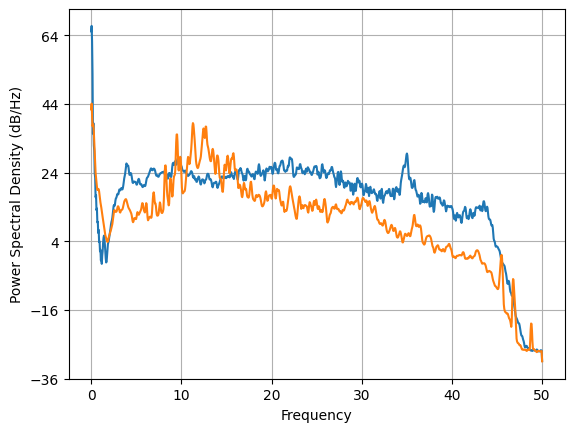

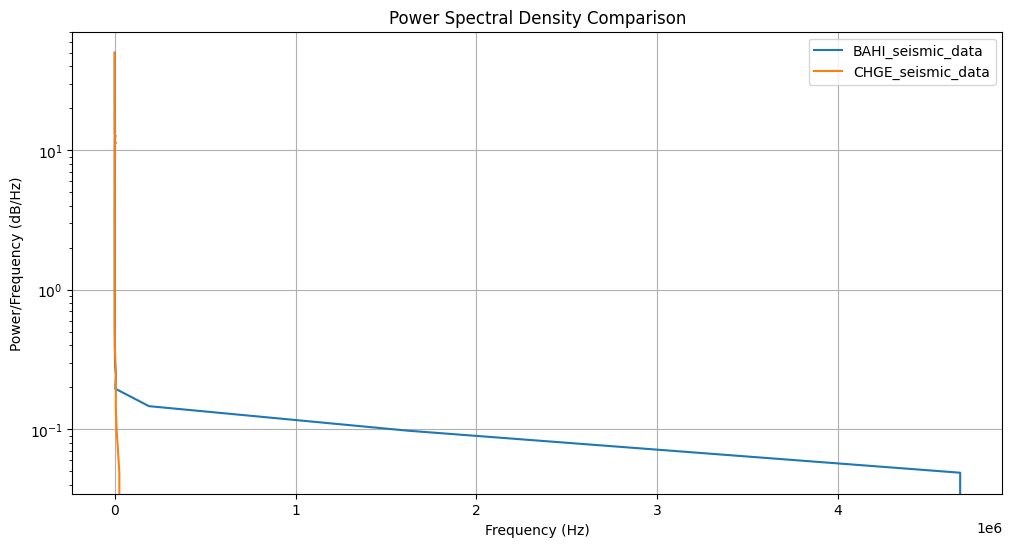

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read

# Load the two MiniSEED waveform data files

st1 = read('/content/sample_data/CHGE_seismic_data.mseed')
st2 = read('/content/sample_data/GOND_seismic_data.mseed')

# Extract the time series data from the traces
data1 = st1[0].data
data2 = st2[0].data

# Calculate power spectral density (PSD)
frequencies1, psd1 = plt.psd(data1, NFFT=1024, Fs=st1[0].stats.sampling_rate, pad_to=2048)
frequencies2, psd2 = plt.psd(data2, NFFT=1024, Fs=st2[0].stats.sampling_rate, pad_to=2048)

# Plot the PSDs
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies1, psd1, label='BAHI_seismic_data')
plt.semilogy(frequencies2, psd2, label='CHGE_seismic_data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1425: RuntimeWarning: invalid value encountered in cast
  return out.astype(result_type)


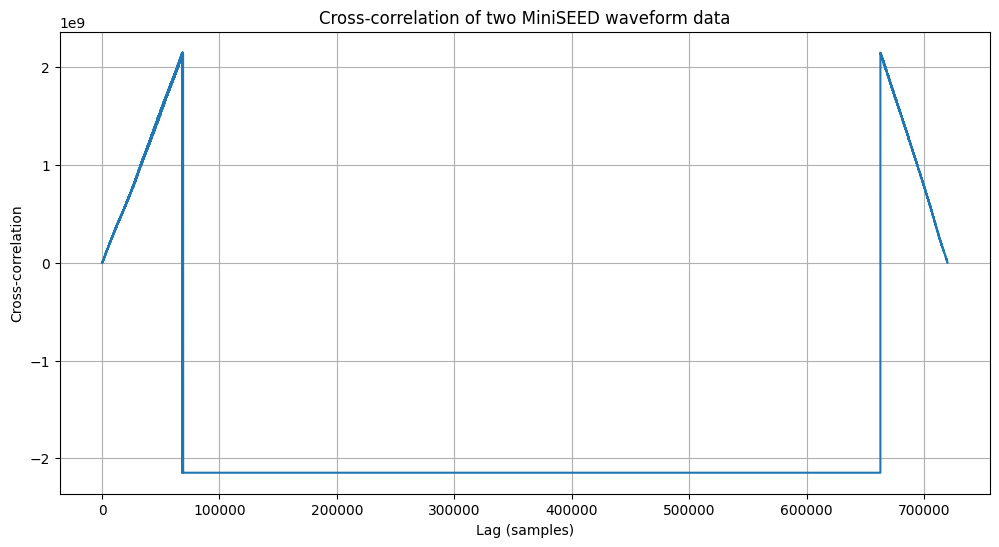

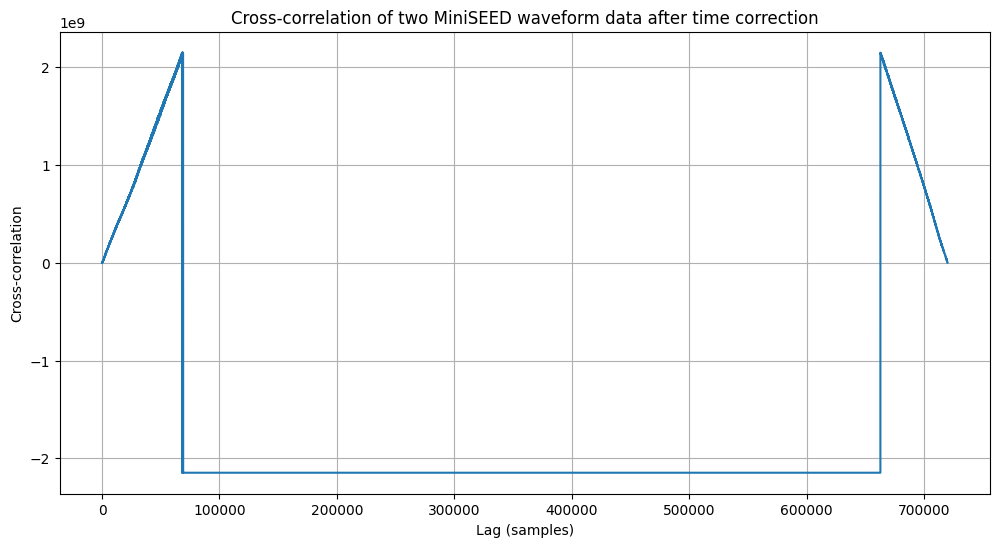

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, Trace, Stream
from scipy.signal import correlate
from scipy.optimize import minimize

# Load the two MiniSEED waveform data files
st1 = read('/content/sample_data/GOND_seismic_data.mseed')
st2 = read('/content/sample_data/CHGE_seismic_data.mseed')

# Extract the time series data from the traces
data1 = st1[0].data
data2 = st2[0].data

# Perform cross-correlation
corr = correlate(data1, data2, mode='full')

# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(corr)
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation of two MiniSEED waveform data')
plt.grid()
plt.show()

# Extract dispersion curves
def misfit_func(params, data1, data2):
    lag = int(params[0])
    corr = correlate(data1, np.roll(data2, lag), mode='valid')
    return -np.max(corr)

result = minimize(misfit_func, x0=[0], args=(data1, data2), bounds=[(-len(data1), len(data1))])
lag = int(result.x[0])

# Apply time shift to data2
data2_shifted = np.roll(data2, lag)

# Create a Stream object to store the shifted waveform
st2_shifted = Stream([Trace(data=data2_shifted, header=st2[0].stats)])

# Perform cross-correlation again
corr = correlate(data1, data2_shifted, mode='full')

# Plot the corrected cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(corr)
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation of two MiniSEED waveform data after time correction')
plt.grid()
plt.show()


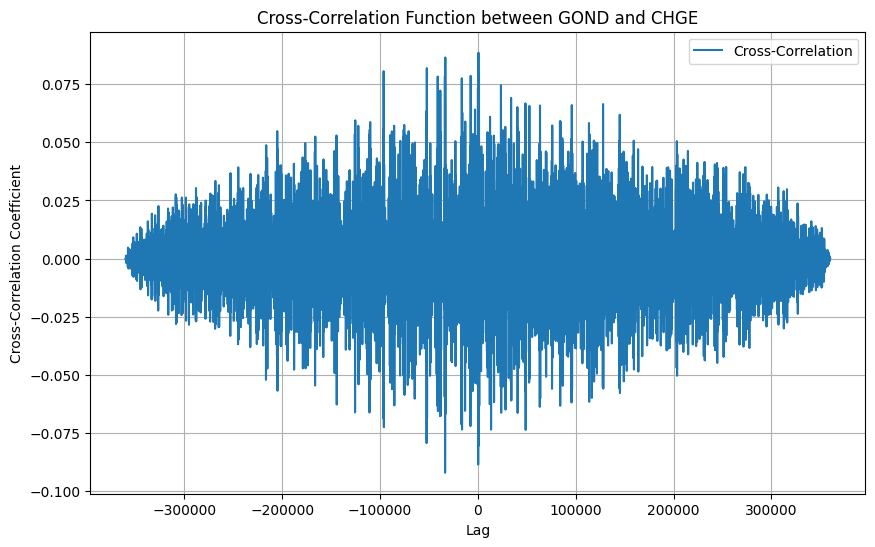

In [27]:
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.cross_correlation import correlate
from obspy.signal.filter import bandpass
import numpy as np

# Load the seismic data
file1 = "/content/sample_data/GOND_seismic_data.mseed"
file2 = "/content/sample_data/CHGE_seismic_data.mseed"
st1 = read(file1)
st2 = read(file2)

# Select the desired trace (assuming only one trace per file)
tr1 = st1[0]
tr2 = st2[0]

# Ensure the traces have the same start and end times
starttime = max(tr1.stats.starttime, tr2.stats.starttime)
endtime = min(tr1.stats.endtime, tr2.stats.endtime)
tr1.trim(starttime, endtime)
tr2.trim(starttime, endtime)

# Ensure the traces have the same number of samples (interpolate if necessary)
if tr1.stats.npts != tr2.stats.npts:
    tr2.interpolate(sampling_rate=tr1.stats.sampling_rate, method='linear')

# Preprocess the data: remove mean, detrend, and filter
tr1.detrend('linear')
tr2.detrend('linear')
tr1.detrend('demean')
tr2.detrend('demean')
tr1.filter('bandpass', freqmin=0.1, freqmax=1.0)
tr2.filter('bandpass', freqmin=0.1, freqmax=1.0)

# Normalize the data by its standard deviation
tr1.data /= np.std(tr1.data)
tr2.data /= np.std(tr2.data)

# Ensure the data arrays have the same length by truncating to the shortest length
min_length = min(len(tr1.data), len(tr2.data))
tr1.data = tr1.data[:min_length]
tr2.data = tr2.data[:min_length]

# Perform cross-correlation
corr = correlate(tr1.data, tr2.data, min_length - 1, normalize=True)
lags = np.arange(-min_length + 1, min_length)

# Plot the cross-correlation function (collogram)
plt.figure(figsize=(10, 6))
plt.plot(lags, corr, label='Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation Coefficient')
plt.title('Cross-Correlation Function between GOND and CHGE')
plt.legend()
plt.grid()
plt.show()


In [33]:
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.cross_correlation import correlate
from obspy.signal.filter import bandpass
import numpy as np
from scipy.fftpack import fft, fftfreq
import pyherman

# Load the seismic data
file1 = "/content/sample_data/GOND_seismic_data.mseed"
file2 = "/content/sample_data/CHGE_seismic_data.mseed"
st1 = read(file1)
st2 = read(file2)

# Select the desired trace (assuming only one trace per file)
tr1 = st1[0]
tr2 = st2[0]

# Ensure the traces have the same start and end times
starttime = max(tr1.stats.starttime, tr2.stats.starttime)
endtime = min(tr1.stats.endtime, tr2.stats.endtime)
tr1.trim(starttime, endtime)
tr2.trim(starttime, endtime)

# Ensure the traces have the same number of samples (interpolate if necessary)
if tr1.stats.npts != tr2.stats.npts:
    tr2.interpolate(sampling_rate=tr1.stats.sampling_rate, method='linear')

# Preprocess the data: remove mean, detrend, and filter
tr1.detrend('linear')
tr2.detrend('linear')
tr1.detrend('demean')
tr2.detrend('demean')
tr1.filter('bandpass', freqmin=0.1, freqmax=1.0)
tr2.filter('bandpass', freqmin=0.1, freqmax=1.0)

# Normalize the data by its standard deviation
tr1.data /= np.std(tr1.data)
tr2.data /= np.std(tr2.data)

# Ensure the data arrays have the same length by truncating to the shortest length
min_length = min(len(tr1.data), len(tr2.data))
tr1.data = tr1.data[:min_length]
tr2.data = tr2.data[:min_length]

# Perform cross-correlation
corr = correlate(tr1.data, tr2.data, min_length - 1, normalize=True)
lags = np.arange(-min_length + 1, min_length)

# Plot the cross-correlation function (collogram)
plt.figure(figsize=(10, 6))
plt.plot(lags, corr, label='Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation Coefficient')
plt.title('Cross-Correlation Function between GOND and CHGE')
plt.legend()
plt.grid()
plt.show()

# Calculate the Fourier Transform of the cross-correlation function
n = len(corr)
corr_fft = fft(corr)
freqs = fftfreq(n, d=tr1.stats.delta)  # Frequency array

# Only consider positive frequencies
positive_freqs = freqs[:n // 2]
positive_corr_fft = corr_fft[:n // 2]

# Compute the phase spectrum
phase_spectrum = np.angle(positive_corr_fft)

# Manually specify the distance between the two stations (in meters)
distance = 10000  # Example: 10 km, replace with actual distance

# Calculate phase velocity using Herman package
velocity = pyherman.phase_velocity(distance, positive_freqs, phase_spectrum)

# Plot the dispersion curve
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, velocity, label='Phase Velocity')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Velocity (m/s)')
plt.title('Dispersion Curve')
plt.legend()
plt.grid()
plt.show()


ModuleNotFoundError: No module named 'pyherman'